In [3]:
from fastdownload import FastDownload

In [4]:
from PIL import Image
import torch
from torchvision import transforms as tfms
import numpy as np
import cv2

## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from diffusers import StableDiffusionInpaintPipeline

In [5]:
def load_artifacts():
    '''
    A function to load all diffusion artifacts
    '''
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
    unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
    scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)    
    return vae, unet, tokenizer, text_encoder, scheduler

def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

vae, unet, tokenizer, text_encoder, scheduler = load_artifacts()

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.out_proj.weight', 'vision_model.encoder.layers.21.mlp.fc1.weight', 'vision_model.encoder.layers.14.mlp.fc1.weight', 'vision_model.encoder.layers.19.mlp.fc2.bias', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.11.self_attn.k_proj.bias', 'vision_model.encoder.layers.23.self_attn.q_proj.weight', 'vision_model.pre_layrnorm.bias', 'vision_model.encoder.layers.2.mlp.fc1.bias', 'vision_model.encoder.layers.11.mlp.fc2.weight', 'vision_model.encoder.layers.19.self_attn.v_proj.bias', 'vision_model.encoder.layers.20.layer_norm2.bias', 'vision_model.encoder.layers.15.mlp.fc1.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.bias', 'vision_model.encoder.layers.15.layer_norm2.weight', 'vision_model.encoder.layers.4.layer_norm1.weight', 'vision_model

In [6]:
def prompt_2_img_i2i_fast(prompts, init_img, g=7.5, seed=100, strength =0.5, steps=50, dim=512):
    """
    Diffusion process to convert prompt to image
    """
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""], text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Convert the seed image to latent
    init_latents = pil_to_latents(init_img)
    
    # Figuring initial time step based on strength
    init_timestep = int(steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    
    # Adding noise to the latents 
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # We need to scale the i/p latents to match the variance
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), timesteps)
    # Predicting noise residual using U-Net
    with torch.no_grad(): u,t = unet(inp, timesteps, encoder_hidden_states=emb).sample.chunk(2)
         
    # Performing Guidance
    pred = u + g*(t-u)

    # Zero shot prediction
    latents = scheduler.step(pred, timesteps, latents).pred_original_sample
    
    # Returning the latent representation to output an array of 4x64x64
    return latents.detach().cpu()

def create_mask_fast(init_img, rp, qp, n=20, s=0.5):
    ## Initialize a dictionary to save n iterations
    diff = {}
    
    ## Repeating the difference process n times
    for idx in range(n):
        ## Creating denoised sample using reference / original text
        orig_noise = prompt_2_img_i2i_fast(prompts=rp, init_img=init_img, strength=s, seed = 100*idx)[0]
        ## Creating denoised sample using query / target text
        query_noise = prompt_2_img_i2i_fast(prompts=qp, init_img=init_img, strength=s, seed = 100*idx)[0]
        ## Taking the difference 
        diff[idx] = (np.array(orig_noise)-np.array(query_noise))
    
    ## Creating a mask placeholder
    mask = np.zeros_like(diff[0])
    
    ## Taking an average of 10 iterations
    for idx in range(n):
        ## Note np.abs is a key step
        mask += np.abs(diff[idx])  
        
    ## Averaging multiple channels 
    mask = mask.mean(0)
    
    ## Normalizing 
    mask = (mask - mask.mean()) / np.std(mask)
    
    ## Binarizing and returning the mask object
    return (mask > 0).astype("uint8")

def improve_mask(mask):
    mask  = cv2.GaussianBlur(mask*255,(3,3),1) > 0
    return mask.astype('uint8')

In [7]:
def fastDiffEdit(init_img, rp , qp, g=7.5, seed=100, strength =0.7, steps=20, dim=512):
    
    ## Step 1: Create mask
    mask = create_mask_fast(init_img=init_img, rp=rp, qp=qp, n=20)
    
    ## Improve masking using CV trick
    mask = improve_mask(mask)
    
    ## Step 2 and 3: Diffusion process using mask
    output = pipe(
        prompt=qp, 
        image=init_img, 
        mask_image=Image.fromarray(mask*255).resize((512,512)), 
        generator=torch.Generator("cuda").manual_seed(100),
        num_inference_steps = steps
    ).images
    return output[0]

In [8]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
).to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
p = FastDownload().download('https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg?cs=srgb&dl=pexels-helena-lopes-1996333.jpg&fm=jpg&_gl=1*1pc0nw8*_ga*OTk4MTI0MzE4LjE2NjY1NDQwMjE.*_ga_8JE65Q40S6*MTY2Njc1MjIwMC4yLjEuMTY2Njc1MjIwMS4wLjAuMA..')
init_img = load_image(p)
output = fastDiffEdit(init_img, rp = "a horse image", qp="a zebra image")

  0%|          | 0/20 [00:00<?, ?it/s]

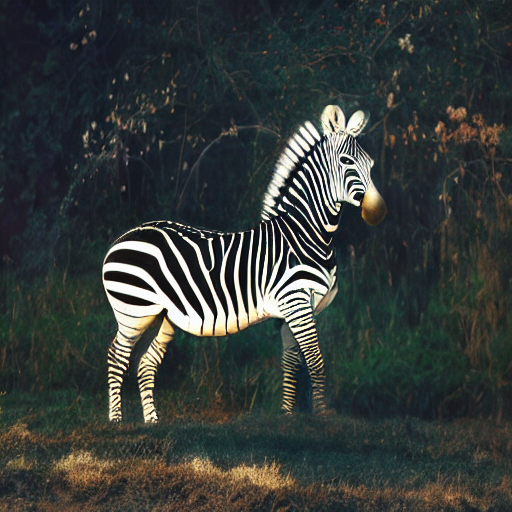

In [10]:
output

In [11]:
def test_func(init_img, rp , qp):
    mask = create_mask_fast(init_img, rp, qp)
    mask = improve_mask(mask)
    return pipe(
        prompt=[qp], 
        image=init_img, 
        mask_image=Image.fromarray(mask*255),#.resize((512,512)), 
        generator=torch.Generator("cuda").manual_seed(100),
        num_inference_steps = 20
    ).images[0]

In [12]:
import gradio as gr

In [14]:
demo = gr.Interface(
    fn=fastDiffEdit, 
    inputs=[
        gr.inputs.Image(shape=(512, 512), type="pil", label = "Upload your image photo"),
        gr.Textbox(label="Describe your image. Ex: a horse image"),
        gr.Textbox(label="Retype the description with target output. Ex: a zebra image")], 
    outputs="image",
    title = "DiffEdit demo",
    description = "DiffEdit paper demo. Upload an image, pass reference prompt describing the image, pass query prompt to replace the object with target object",
    examples = [
        ["horse.jpg", "a horse image", "a zebra image"],
        ["fruitbowl.jpg", "a bowl of fruit", "a bowl of grapes"]],
    enable_queue=True
    )

demo.launch(share=True) 

/home/aayush/miniconda3/envs/fastai/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `enable_queue` is deprecated in `Interface()`, please use it within `launch()` instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7861/
Running on public URL: https://a3a54c93e8e5d9f8.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://www.huggingface.co/spaces)


(<gradio.routes.App at 0x7fdd363c91f0>,
 'http://127.0.0.1:7861/',
 'https://a3a54c93e8e5d9f8.gradio.app')